In [1]:
%matplotlib inline

# 2018-10-15 Un compte rendu sur mon hybride Retine/LGN
Salut Laurent,

Si tu lis ceci, c'est que j'ai survécu à la formation de sécurité incendie. Youpi !

Plus sérieusement, comme je t'avais montré vendredi dernier en coup de vent, j'ai adapté un framework qu'il y avait dans le push/pull de Kremkow et dans un papier de Koprinkova. C'est une simplification de la rétine+LGN comme un seul filtre spatiotemporel : le spatial est une différence de deux gaussiennes qui mime les centres ON/OFF et le temporel mime la cinétique d'activation du LGN comme décrite par Cai 97(https://www.ncbi.nlm.nih.gov/pubmed/9307134).

Le modèle général est celui de Contrast invariant orientation tuning, de Troyer (98) et un stagiaire de Davison en a fait un petit bout pour un challenge google de 2014 (http://www.neuralensemble.blogspot.com/2014/06/gsoc-open-source-brain-retinal-filter-i.html).

En mélangeant tout les snippets de code et les concepts des papiers, j'ai produit un système dynamique qui va nous permettre de mimer plusieurs dizaines (voir plus ?) de champ récepteurs pour donner un input à notre modèle cortical. Libre à nous de tuner les deux filtres pour ajouter des effets, ou de passer à un modèle plus bioréaliste si jamais on a du temps (mais soyons honnête, on en a jamais).

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def find_middle(a_list):
    middle = len(a_list)/2
    return a_list[int(middle)]

# Filtres spatial translatable
C'est la différence de deux gaussiennes qui nous donne un center/surround très joli. La j'ai lourdement piqué le code de neuralensemble parce qu'il était très correct. Juste changé la manière dont la grille et les calculs sont fait, comme ça on tourne plus vite et on peut translater à l'infini les filtres.

In [3]:
# Un premier filtre, spatial avec center-surround (voir et citer MARR ?)


def spatial_filter(wx=5., wy=5., xres=.1, yres=.1, sigma_center=1., sigma_surround=1.2,
                   x_trans=0, y_trans=0, theta=0, end_multiplier=-1.):
    ''' wx, wy : x/y width
    xres, yres : x/y resolution
    sigma_center : U.A related to the center of the circle
    sigma_surround : U.A related to the surround of of the circle
    x_trans, y_trans : 0, 0 #translation of the filter
    end_mutiplier : decreases the spatial filter response and triggers ON(negative value) or OFF(positives)
    center-surround fields
    theta = 0 : rotates the whole filter '''

    # theta = theta*np.pi/180 #je vais finir par appeller ça la conversion perrinet
    N = 2 * int(wx / yres) + 1
    x = np.linspace(-wx, wx, N, endpoint=True)
    y = np.linspace(-wy, wy, N, endpoint=True)
    X, Y = np.meshgrid(x, y)

    #X_ = np.cos(theta) * X + np.sin(theta) * Y
    #Y = -np.sin(theta) * X + np.cos(theta) * Y
    #X = X_

    radius = np.sqrt((X-x_trans)**2 + (Y-y_trans)**2)
    center = (1.0 / sigma_center**2) * np.exp(-.5*(radius / sigma_center)**2)
    surround = (1.0 / sigma_surround**2) * \
        np.exp(-.5*(radius / sigma_surround)**2)
    #print('center.sum()', center.sum())
    #print('surround.sum()', surround.sum())
    Z = surround - center
    Z *= end_multiplier
    return X, Y, Z

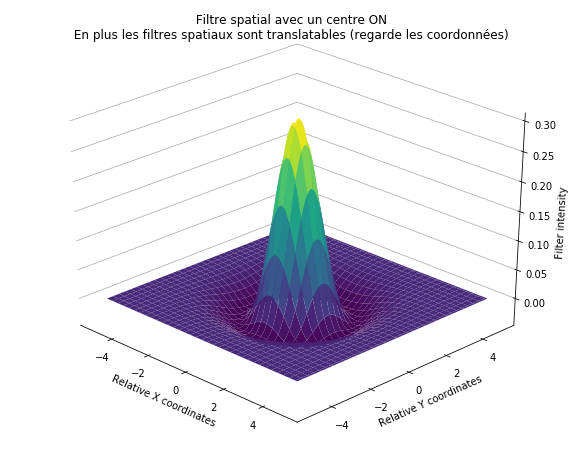

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

X, Y, Z = spatial_filter(x_trans=0, y_trans=0)


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.cm.viridis)

ax.set_zlabel('Filter intensity')
ax.set_xlabel('Relative X coordinates')
ax.set_ylabel('Relative Y coordinates')

ax.xaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)
ax.yaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)
#ax.zaxis._axinfo["grid"]["color"] = (1,1,1,0)

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.set_title(''' Filtre spatial avec un centre ON\n En plus les filtres spatiaux sont translatables (regarde les coordonnées)''')

ax.view_init(azim=-45, elev=30)

# Filtre temporel continu
Cai a montré que le décours temporel des réponses du LGN du chat permettait d'expliquer en partie le pattern de Gabor qu'on voit dans les champs selectifs à l'orientation de V1 au cours de stimulations visuelle. Regarde la figure 2 de son papier dans l'intro, mais j'imagine que tu dois déjà le connaitre :-)

In [127]:
def temporal_filter(t = 1 , response_time = 175, refrac_time = 50,
                   K1 = .92, c1 = 0.2, n1 = 7, t1 = -6,
                   K2 = .2, c2 = .12, n2 = 8, t2 = -6,
                   baseline = 0.001):
    '''
    Arguments :
    --> time = time for which the filter's reponse is calculated
    --> total_time = time the filter takes to do a full response, starting from 0, peaking, undershooting
    and going to 0 again
    --> refrac_time = refraction time after which the filter can be activated again
    --> other params are as f(x) = K * [ (c*(t-1))**2 * e^(-c1(t-t1)) ] / [ (n**2) * e^-n]
    (see wikipedia for formula)
    -->-->K relates to the height, c to the opening
    '''
    
    k = int(t//(response_time+refrac_time)) #get the signal period we're currently in
    #reset the filter if the refraction is over
    if t > (response_time+refrac_time)*k :
        t = t - (response_time+refrac_time)*k
    
    #t = np.arange(0, total_time*t_res, t_res)
    p1 = baseline+K1 * ( (c1 * (t - t1))**n1 * np.exp(-c1 * (t-t1))) / (n1**2)*np.exp(-n1)
    p2 = K2 * ( (c2 * (t - t2))**n2 * np.exp(-c2 * (t-t2))) / (n2**2)*np.exp(-n2)
    return (p1-p2)*90 #oups je me suis planté d'un facteur 90, c'est un sacré miss

Text(0.5,1,'Temporal filter with a non-zero baseline')

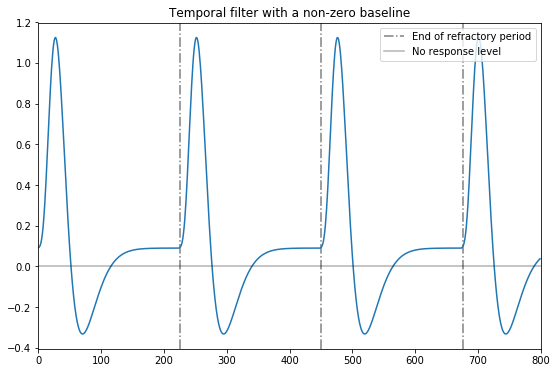

In [128]:
ys = []
plt.figure(figsize = (9,6))
for i in np.linspace(0, 800, 800 ):
    ys.append(temporal_filter(t = i))
    if int(i) == 175+50 or int(i) == 2*(175+50) or int(i) == 3*(175+50) : #oh c'est pas beau
        plt.axvline(i, color = 'k', linestyle = '-.', alpha = .5,
                   label = 'End of refractory period' if int(i) == 175+50 else '')
        
plt.plot(ys)
plt.xlim(0, 800)
plt.axhline(0, color = 'k', alpha = .3, label = 'No response level')
plt.legend(loc = 1)
plt.title('Temporal filter with a non-zero baseline')

La même chose avec une convolution

Text(0.5,1,'Temporal filter with a non-zero baseline')

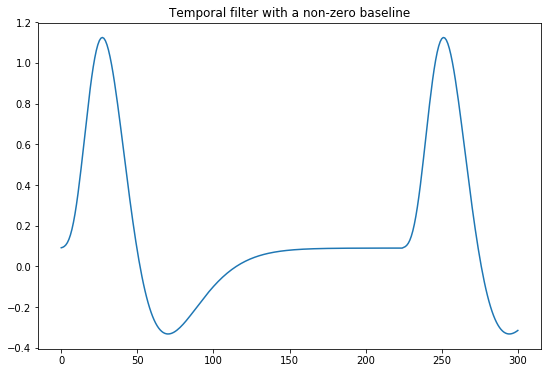

In [129]:
t = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]

plt.figure(figsize = (9,6))
plt.plot(t)
plt.title('Temporal filter with a non-zero baseline')

In [140]:
stimuli[:,:,1].shape

(20, 20)

In [144]:
inp = np.zeros_like(t)
for t_imp in [50,40, 60, 105,130]:
    inp[t_imp] = 1
    
inp = []
for i in range(total_time):
    tempo_var = scipy.signal.convolve2d(stimuli[:,:,i], Z)
    inp.append(tempo_var)
    
ys = np.convolve(inp, t, 'full')

plt.figure(figsize = (9,6))

        
plt.plot(inp)
plt.plot(ys)
plt.xlim(0, 800)
#plt.axhline(0, color = 'k', alpha = .3, label = 'No response level')
#plt.legend(loc = 1)
plt.title('Temporal filter with a non-zero baseline')

ValueError: object too deep for desired array

# Filtre spatiotemporel
Ensuite il suffit simplement de multiplier les composants pour faire un filtre spatiotemporel (enfin c'est mon intuition, mais peut être ai-je tort ?)

In [10]:
def spatiotemporal_filter(spatio_X, spatio_Y, spatio_Z, tempo):
    '''
    Returns a 4D spatiotemporal filter, structure as : of tempo length with each element being X/Y/Z,
    each X/Y/Z having the samedimensions as that of the given spatial filter. 
    Temporal resolution is the same as the temporal filter
    --> spatio_X, Y, Z : spatial filter
    --> tempo = temporal filter
    '''
    st_filter = [] #bizarrement c'est plus rapide qu'une array
    for i, temporal_function in enumerate(tempo):
        st_filter.append(Z*temporal_function)
    
    return st_filter

In [11]:
X, Y, Z = spatial_filter()
T = 800
t = np.arange(T)
K = temporal_filter(t)
st = Z[:, :, None] * ys[None, None, :]
print('st.shape', st.shape)
print('st.max()', st.max())
print('st.min()', st.min())

st.shape (101, 101, 800)
st.max() 0.711580502327531
st.min() -0.23879927908018228


interesting_times [0, 37, 75, 112, 150, 187, 225, 262, 300]


Text(0.45,0.99,'Spatiotemporal filter level\nover multiple temporal filter repetitions')

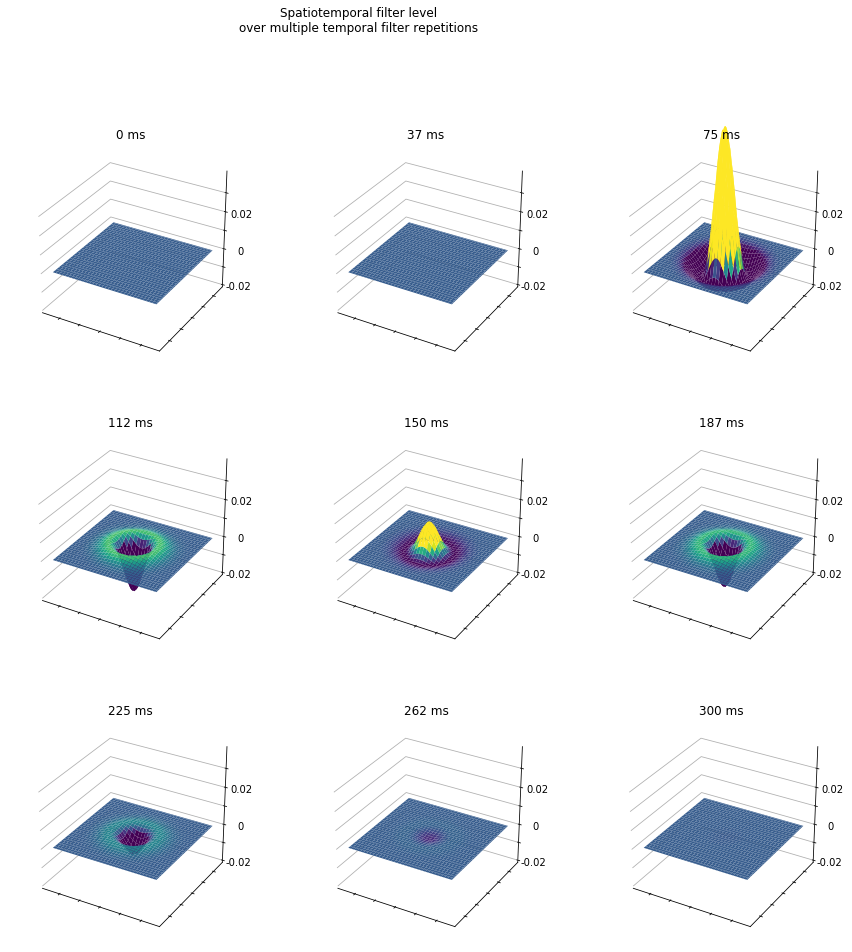

In [12]:
# c'est pas propre mais j'ai eu des tas de pb avec matplotlib alors on va la jouer comme ça
# pas besoin de s'embêter avec les colormaps vu que c'est la meme que celle de la 3D, qui va surement
# finir a coté sur le rapport
plt.figure(figsize=(15, 15))
#plt.subplots_adjust(bottom=.7, top=.97, wspace=.02, hspace=.02, right=.75)

interesting_times = [int(k) for k in np.linspace(0, 300, 9)]

print('interesting_times', interesting_times)
for i, t0 in enumerate(interesting_times):
    ax = plt.subplot(3, 3, i+1, aspect='equal', projection='3d')
    ax.plot_surface(X, Y, st[:, :, t0], vmin=-.02, vmax=.05,
                    cmap=plt.cm.viridis)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([-.02, '', 0, '', 0.02, '', 0.04, ''])

    ax.set_zlim(-.2, .4)
    ax.xaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)
    ax.yaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)
    #ax.zaxis._axinfo["grid"]["color"] = (1,1,1,0)

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_title('%s ms' % (t0), color='k')

#plt.tight_layout()
plt.suptitle(
    'Spatiotemporal filter level\nover multiple temporal filter repetitions', x=.45, y=.99)
#plt.savefig('./figs/2018_10_12_SpatioTemporal_filter3D_800ms.pdf', format = 'pdf', dpi = 200,bbox_inches = 'tight' )

# Réponse a une stimulation bruitée
Maintenant je montre des arrays aléatoire au filtre et on voit bien que sa réponse suit celle du filtre temporel.

In [123]:
#basic 4 level pattern, the same size as the filter
np.random.seed(42)
stimuli = 2.*np.random.randint(2, size = (int(wx/(xres/2)), int(wy/(yres/2)), total_time))
stimuli *= 0.01
signal = np.zeros_like(stimuli)
signal[11, 11, 18] = 1
signal[11, 11, 230] = 1
stimuli += signal

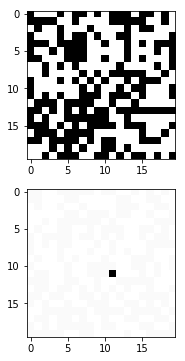

In [52]:
fig, axs = plt.subplots(2,figsize = (8,6))

axs[0].imshow(stimuli[:, :, 17], cmap = plt.cm.binary)
axs[1].imshow(stimuli[:,:,250], cmap = plt.cm.binary)

plt.show()

In [53]:
import scipy.signal
import time

convos = []
for i in range(total_time):
    then = time.time()
    output = scipy.signal.convolve2d(stimuli[:,:,i], st[:,:,i], mode = 'same')
    convos.append(output)

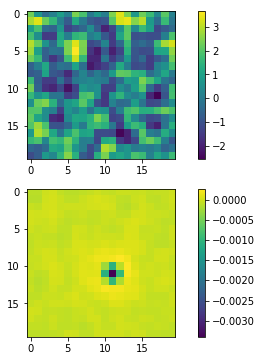

In [119]:
fig, axs = plt.subplots(nrows = 2, figsize = (8,6))
axs[0].imshow(convos[17])
fig.colorbar(axs[0].imshow(convos[17]), ax = axs[0])
axs[1].imshow(convos[180])
fig.colorbar(axs[1].imshow(convos[230]))

In [76]:
Z = Z[:-1,:-1]

# C'est parce que le filtre temporel n'est plus discretisé par les ajouts de Laurent, à voir cet aprem.

In [124]:
def activation_temporal_filter(X,Y,Z,t,filtertime, baseline,
                            activation_threshold, refractory_period,
                            stim, stimtime):
    '''
    An activation-based temporal filter, that only starts after the associated spatial filter as detected
    something above the activation_threshold. It is used to convert a regular temporal filterinto a more 
    realist one, in the sense it works like an adaptative response and not an oscillator
    Args :
    --> X,Y,Z = Spatial filter
    --> t, filtertime, baseline = Temporal filter and associated total time, as well as the baseline
    --> activation_threshold = Threshod above which the spatial filter is activated
    --> refractory_period = Period during which the modified temporal filter becomes inactive
    --> stim, stimtime = Stimulus and associated stimulus total time, usually equals to the filtertime
    '''
    
    v2_filter = []
    deactivation_delay = 0
    for i in np.linspace(0,filtertime-1, filtertime) :
        activation = np.max(Z*stim[:,:,int(i)])
        
        if deactivation_delay == 0 :
            if activation < activation_threshold : #the spatial hasn't seen anything
                v2_filter.append(baseline) #don't forget the 90 corrective factor
            else : #we start a new countdown
                deactivation_delay = refractory_period
                print('The spatial filter started detecting something at %s ms' % int(i))
        else : #we're doing a reponse
            deactivation_delay -=1
            v2_filter.append(temporal_filter(refractory_period-deactivation_delay))
            
    return v2_filter

In [125]:
acto_tempo = activation_temporal_filter(X=X,Y=Y,Z=Z, baseline=0.001*90,
                                             t = t, filtertime = total_time,
                                             activation_threshold = 4.5, refractory_period = 225,
                                             stim = stimuli, stimtime = total_time)

The spatial filter started detecting something at 18 ms


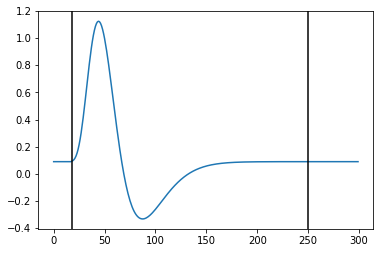

In [126]:
plt.plot(acto_tempo)
plt.axvline(18, color = 'k')
plt.axvline(250, color = 'k')

In [113]:
import scipy.ndimage
import time

then = time.time()
output = scipy.ndimage.correlate(st, stimuli, mode='wrap')
print('Done in %s s' % ( time.time() - then ) )

MemoryError: 

In [ ]:
plt.imshow(output[:,:,18])
plt.colorbar()

In [ ]:
print ('stimuli.shape', stimuli.shape)
print ('st.shape', st.shape)
print ('output.shape', output.shape)

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(output[11, 11, :], color = 'b', label = 'Filter response')
#plt.plot(t, color = 'r', label = 'Temporal filter')
plt.legend(loc = 1) #autobest
plt.title('Spatiotemporal filter response to a noise')
plt.xlabel('Time(ms)')
plt.ylabel('Filter response')

In [ ]:
output /= 100.
print('output.max()', output.max())
print('output.min()', output.min())

In [ ]:
for i, t0 in enumerate(interesting_times):
    print( output[:, :, t0].shape)

In [ ]:
# c'est pas propre mais j'ai eu des tas de pb avec matplotlib alors on va la jouer comme ça
# pas besoin de s'embêter avec les colormaps vu que c'est la meme que celle de la 3D, qui va surement
# finir a coté sur le rapport
plt.figure(figsize=(8, 8))
#plt.subplots_adjust(bottom=.7, top=.97, wspace=.02, hspace=.02, right=.75)

interesting_times = [int(k) for k in np.linspace(0, 150, 9)]

print('interesting_times', interesting_times)
for i, t0 in enumerate(interesting_times):
    ax = plt.subplot(3, 3, i+1, aspect='equal')
    ax.pcolormesh(output[:, :, t0], cmap=plt.cm.viridis)
    #ax.plot_surface(X, Y, output[:, :, t0], vmin=-52, vmax=52,
    #                cmap=plt.cm.viridis)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('%s ms' % (t0), color='k')

#plt.tight_layout()
plt.suptitle(
    'Spatiotemporal filter level\nover multiple temporal filter repetitions', x=.45, y=.99)
#plt.savefig('./figs/2018_10_12_SpatioTemporal_filter3D_800ms.pdf', format = 'pdf', dpi = 200,bbox_inches = 'tight' )

# Ca marche aussi en réponse a un pattern constant

In [ ]:
#Et maintenant avec un vrai stim
xx, yy = np.mgrid[:100, :100]
circle = (xx - 50) ** 2 + (yy - 50) ** 2

japanese_flag = (circle < (1000))
plt.imshow(japanese_flag, cmap = plt.cm.Reds)

In [ ]:
total_resp = []
for i, st_response in enumerate(st):
    total_resp.append(np.sum(st_response * japanese_flag))

plt.figure(figsize = (8,6))
plt.plot(total_resp, color = 'b', label = 'Filter response')
plt.plot(t, color = 'r', label = 'Temporal filter')
plt.legend(loc = 0) #autobest
plt.title('Spatiotemporal filter response to a constant circle pattern')
plt.xlabel('Time(ms)')
plt.ylabel('Filter response')
#plt.savefig('./figs/2018_10_12_STFilter_Reponse_CONSTANT.pdf', format = 'pdf', dpi = 200,bbox_inches = 'tight' )

# Et avec un pattern se déplaçant


In [ ]:
jap_flags = []
stim_time = 200

for i in range(stim_time):
    #Et maintenant avec un vrai stim
    xx, yy = np.mgrid[:100, :100]
    circle = (xx -  (i/2)) ** 2 + (yy - (i/2)) ** 2

    japanese_flag = (circle < (1000))
    jap_flags.append(japanese_flag)

filter_over_stim = total_time/stim_time #convertion rate from filter to stim

jap_resp = []
for i, st_response in enumerate(st):
    jap_resp.append(np.sum(st_response * jap_flags[int(i/filter_over_stim)]))
    

plt.figure(figsize = (8,6))

plt.plot(jap_resp, color = 'b', label = 'Filter response')

plt.axvline(35*filter_over_stim, color = 'k', linestyle = '-', label = 'Pattern enters OFF surround',
           alpha = .5)
plt.text(-8, 6, 'Pattern enters\nOFF surround')

plt.axvline(45*filter_over_stim, color = 'k', linestyle = '-', label = 'Pattern enters ON center',
           alpha = .8)
plt.text(46*filter_over_stim, 6, 'Pattern enters\nON center')

'''plt.axvline(100*filter_over_stim, color = 'k', linestyle = '-', label = 'Pattern centered ON center',
           alpha = 1)
plt.text(101*filter_over_stim, 6, 'Pattern centered on\nON center')'''

plt.axvline(160*filter_over_stim, color = 'k', linestyle = '-', label = 'Pattern leaves OFF surround',
           alpha = .8)
plt.text(123*filter_over_stim, 6, 'Pattern leaves\nON center')
plt.axvline(170*filter_over_stim, color = 'k', linestyle = '-', label = 'Pattern leaves ON center',
           alpha = .5)
plt.text(171*filter_over_stim, 6, 'Pattern leaves\nOF surround')


plt.ylim(-2.5, 7)
plt.xlim(-15,825)
#plt.legend(loc = (1.01, .72)) 
plt.title('Spatiotemporal filter response to a moving circle pattern')
plt.xlabel('Time(ms)')
plt.ylabel('Filter response')
#plt.savefig('./figs/2018_10_12_STFilter_Reponse_MOVING.pdf', format = 'pdf', dpi = 200,bbox_inches = 'tight' )

# Par contre la réponse temporelle n'est pas correcte !
Les modèles que j'ai vu (et le mien jusque la) utilisent la réponse temporelle comme un oscillateur, c'est a dire que la réponse du LGN varie peu importe l'activation du filtre spatial. Alors que biologiquement on peut s'attendre plutot à ce que le décours temporel se lance SSI il y a eu une activation du filtre spatial, donc de la rétine (on est dans le cas de la réponse adaptative neuronale canonique).

Donc je modifie le filtre temporel pour qu'il s'active si le spatial s'est activé :

In [ ]:
def activation_temporal_filter(X,Y,Z,t,filtertime, baseline,
                            activation_threshold, refractory_period,
                            stim, stimtime):
    '''
    An activation-based temporal filter, that only starts after the associated spatial filter as detected
    something above the activation_threshold. It is used to convert a regular temporal filterinto a more 
    realist one, in the sense it works like an adaptative response and not an oscillator
    Args :
    --> X,Y,Z = Spatial filter
    --> t, filtertime, baseline = Temporal filter and associated total time, as well as the baseline
    --> activation_threshold = Threshod above which the spatial filter is activated
    --> refractory_period = Period during which the modified temporal filter becomes inactive
    --> stim, stimtime = Stimulus and associated stimulus total time, usually equals to the filtertime
    '''
    
    v2_filter = []
    deactivation_delay = 0
    for i in np.linspace(0,filtertime, filtertime) :
        activation = np.max(Z*stim[int(i)])
    
        if deactivation_delay == 0 :
            if activation < activation_threshold : #the spatial hasn't seen anything
                v2_filter.append(baseline*90) #don't forget the 90 corrective factor
            else : #we start a new countdown
                deactivation_delay = refractory_period
                print('The spatial filter started detecting something at %s ms' % int(i))
        else : #we're doing a reponse
            deactivation_delay -=1
            v2_filter.append(temporal_filter(refractory_period-deactivation_delay))
            
    return v2_filter

In [ ]:
############
# Constants
############
baseline = 0.001
total_time = 800

########
# STIM
########
jap_flags = []
for i in range(total_time+1):
        xx, yy = np.mgrid[:100, :100]
        circle = (xx - 50) ** 2 + (yy - 50) ** 2
        japanese_flag = (circle > (7000))
        jap_flags.append(japanese_flag)
        
for i in [300, 600, 610, 620, 700]:
    xx, yy = np.mgrid[:100, :100]
    circle = (xx - 50) ** 2 + (yy - 50) ** 2
    japanese_flag = (circle < (500))
    jap_flags[i] =japanese_flag


###########
# Filters 
###########
X,Y,Z = spatial_filter(wx = wx, wy = wy, xres = xres, yres = yres)   
temporal = [temporal_filter(i) for i in np.linspace(0,total_time, resolution_time)]
activation_temporal = activation_temporal_filter(X=X,Y=Y,Z=Z, baseline=baseline,
                                             t = temporal, filtertime = total_time,
                                             activation_threshold = .001, refractory_period = 225,
                                             stim = jap_flags, stimtime = total_time)
new_st = spatiotemporal_filter(spatio_X = X, spatio_Y = Y, spatio_Z = Z,
                                   tempo = activation_temporal)


############
# Activation
############
jap_resp= []
for i, st_response_new in enumerate(new_st):
    jap_resp.append(np.sum(st_response_new * jap_flags[int(i)]))

####
# Plot the two filters
####
plt.figure(figsize = (8,6))
for i in [300, 600, 610, 620, 700]:
    plt.axvline(i, color = 'k', linestyle = '-.', label = 'On center stimulated' if i == 300 else '',
               alpha = .6)
plt.plot(jap_resp, label = 'Activation-based Spatiotemporal filter', color = 'b')
plt.plot(activation_temporal, label = 'Associated temporal filter', color = 'orange')
plt.xlabel('Time(ms)')
plt.ylabel('Filter activation')
plt.legend()
plt.title('Spatiotemporal with activation based temporal decays')
plt.savefig('./figs/2018_10_15_Activation_based_ST_response.pdf', format = 'pdf', dpi = 200,bbox_inches = 'tight' )
plt.show()


# Et je fais un paradigme ou un japanese flag bouge de gauche a droite pour vérifier  

In [ ]:
#A stim that moves from left to right now
jap_flags = []
for i in range(total_time+1):
        xx, yy = np.mgrid[:100, :100]
        circle = (xx - 50) ** 2 + (yy - int(i/8)) ** 2
        japanese_flag = (circle < 100)
        jap_flags.append(japanese_flag)

X,Y,Z = spatial_filter()   
temporal = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]
activation_temporal = activation_temporal_filter(X=X,Y=Y,Z=Z, baseline=baseline,
                                             t = temporal, filtertime = total_time,
                                             activation_threshold = .001, refractory_period = 225,
                                             stim = jap_flags, stimtime = total_time)
new_st = spatiotemporal_filter(spatio_X = X, spatio_Y = Y, spatio_Z = Z,
                                   tempo = activation_temporal)

plt.figure(figsize = (7,7))
plt.contourf((X+2)*25,(Y+2)*25,(Z+2)*25, alpha = .7)
plt.imshow(jap_flags[240])
plt.title('Example stim at 120 ms')

plt.pause(.1)

jap_resp= []
for i, st_response_new in enumerate(new_st):
    jap_resp.append(np.sum(st_response_new * jap_flags[int(i)]))

    
plt.figure(figsize = (8,6))
plt.plot(jap_resp, label = 'Activation-based Spatiotemporal filter', color = 'b')
plt.plot(activation_temporal, label = 'Associated temporal filter', color = 'orange')
plt.xlabel('Time(ms)')
plt.ylabel('Filter activation')
plt.legend()
plt.title('Spatiotemporal with activation based temporal decays')

# Conclusion : Maintenant il y a plus qu'a utiliser la réponse du Ret/LGN pour moduler un spike train et on a un input bricolé pour la selectivité à l'orientation du cortex.

## C'est sur que c'est un peu brut de décoffrage, mais qu'en penses-tu ?